<a href="https://colab.research.google.com/github/rui-machado/ML-Projects/blob/master/COVID19_Portugal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Setup PySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!ls
!gunzip -c spark-2.4.5-bin-hadoop2.7.tgz | tar xvf -
!pip install -q findspark
!pwd

In [0]:
# Setup env variables
import os
import findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
findspark.init()
# Create a local Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
# Load libraries
from datetime import datetime,timedelta
from pyspark.sql.functions import datediff,current_date,to_date, lit, min as smin
from scipy.optimize import curve_fit
import numpy as np
from scipy.optimize import fsolve
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Read data
df = spark.read.csv('COVID_PT.csv', sep=';',header=True)
df.head()

In [0]:
# Prepare data
df_data = df.select('Data','Casos_Total')

# Clean columns
df_data = df_data.withColumn("Data", to_date("Data","dd/MM/yyyy").alias("to_date"))

# Compute days since infection and add as column
first_day = df_data.select(smin("Data")).collect()
df_data = df_data.withColumn('DataNumber', lit(1)+datediff(df_data["Data"],lit(first_day[0][0])).alias("datediff"))

df_data.show()

Source: https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

Logistic Model

In [22]:
# Set curve functions
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

# Prepare variables for curve fitting
y = df_data.rdd.map(lambda x: float(x.Casos_Total)).collect()
x = df_data.rdd.map(lambda x: int(x.DataNumber)).collect()

# Fit to curve
fit = curve_fit(logistic_model,x,y)
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# Square root of previous given std - errors
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
error_a = errors[0]
error_b = errors[1]
error_c = errors[2]

# Analyze a
print("Pico de infeção é esperado após {} dias com erro +/- de {}".format(round(b),round(error_b)))

# Analyze b
fim_pandemia = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
print("Fim de pandemia é esperado após {} dias.".format(round(fim_pandemia)))

# Analyze c
print("Número esperado de infetados é: {} pessoas com erro +/- de {}".format(round(c),round(error_c)))

Pico de infeção é esperado após 20.0 dias com erro +/- de 1.0
Fim de pandemia é esperado após 42 dias.
Número esperado de infetados é: 2471.0 pessoas com erro +/- de 296.0


Plot

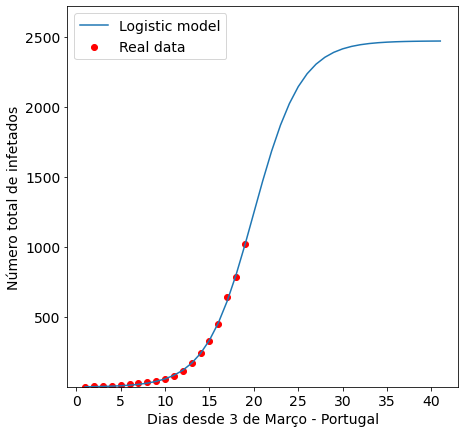

In [23]:
pred_x = list(range(max(x),fim_pandemia))

plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
plt.legend()
plt.xlabel("Dias desde 3 de Março - Portugal")
plt.ylabel("Número total de infetados")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

In [24]:
# Previsões
[{"Dia {}".format(i) : "Infetados: {}".format(round(logistic_model(i,fit[0][0],fit[0][1],fit[0][2])))} for i in x+pred_x if i>len(x)]

[{'Dia 20': 'Infetados: 1245.0'},
 {'Dia 21': 'Infetados: 1473.0'},
 {'Dia 22': 'Infetados: 1685.0'},
 {'Dia 23': 'Infetados: 1871.0'},
 {'Dia 24': 'Infetados: 2024.0'},
 {'Dia 25': 'Infetados: 2145.0'},
 {'Dia 26': 'Infetados: 2237.0'},
 {'Dia 27': 'Infetados: 2305.0'},
 {'Dia 28': 'Infetados: 2355.0'},
 {'Dia 29': 'Infetados: 2390.0'},
 {'Dia 30': 'Infetados: 2415.0'},
 {'Dia 31': 'Infetados: 2432.0'},
 {'Dia 32': 'Infetados: 2444.0'},
 {'Dia 33': 'Infetados: 2453.0'},
 {'Dia 34': 'Infetados: 2459.0'},
 {'Dia 35': 'Infetados: 2463.0'},
 {'Dia 36': 'Infetados: 2465.0'},
 {'Dia 37': 'Infetados: 2467.0'},
 {'Dia 38': 'Infetados: 2469.0'},
 {'Dia 39': 'Infetados: 2469.0'},
 {'Dia 40': 'Infetados: 2470.0'},
 {'Dia 41': 'Infetados: 2471.0'}]

Analysis of residuals

In [10]:
y_pred_logistic = [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x]
y_pred_exp =  [exponential_model(i,exp_fit[0][0], exp_fit[0][1], exp_fit[0][2]) for i in x]
print(mean_squared_error(y,y_pred_logistic))
print(mean_squared_error(y,y_pred_exp))

86.3787907676866
323.16455446371685
